In [1]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import feature_calculators
from typing import Optional, Union, Tuple, Iterable, Callable
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
from warnings import warn
from pathlib import Path
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from datetime import timedelta, datetime
import matplotlib.dates as mdates

1. Cluster based on from "potential_features.json"
2. Based on feature importance, just use half(0.5) of potential features (filter_features function)
3. Cluster based on filtered "features"

In [2]:
def truncated_mean(x: Union[pd.Series, np.ndarray], q: float) -> float:
    """
    Args:
        x: The timeseries to extract features of
        q: The percentage of points higher and lower than p to ignore (0, 0.5)
    Returns:
        The truncated mean with the outlier values ignored
    """
    lower_bound = np.quantile(x, q)
    upper_bound = np.quantile(x, 1-q)
    valid_indices =  np.where((x > lower_bound) & (x < upper_bound))
    return np.mean(x[valid_indices])

TSFRESH_SETTINGS = {
    "variation_coefficient": None, 
    "mean": None
}

fc_settings = TSFRESH_SETTINGS

with open("data/potential_features.json", "r") as f:
    fc_settings = json.load(f)

for f_or_function_name, args in list(fc_settings.items()):
    func = getattr(feature_calculators, f_or_function_name, None)
    if func is None:
        func = globals().get(f_or_function_name, None)
        if func is None:
            warn(f"Function {f_or_function_name} not found. Ignored.")
        else:
            del fc_settings[f_or_function_name]
            fc_settings[func] = args


In [3]:
def cluster(features: np.ndarray, n_clusters: int, max_starts: int = 75
        ) -> Tuple[Callable, np.ndarray, np.ndarray, float]:
    """
    Cluster the given features into n_clusters max_starts number of times, 
        and maximize the mean log expectation of the Gaussian Mixture Model
    
    Args:
        features: The features to cluster
        n_clusters: The number of clusters (mixture components to have)
        max_starts: The max number of random states to try
    Returns:
        A tuple of (The gmm model, 
            The predicted labels (array of shape (n_samples, )),
            The predicted scores of each sampler for each component (array of shape (n_samples, n_components)),
            The mean log expectation)
    """

    #scaled_features = scale(features, with_mean=True)
    scaled_features = features
    scores = []

    for i in range(max_starts):
        gmm = GaussianMixture(random_state=i, 
            n_components=n_clusters, n_init=1, init_params="k-means++", 
            covariance_type="diag", max_iter=300)
        labels = gmm.fit_predict(scaled_features)
        score = gmm.score(scaled_features)
        scores.append([gmm, labels, gmm.predict_proba(scaled_features), score])

    scores.sort(key= lambda x:x[-1])
    return scores[-1]


def _train_single_tree(seed, scaled_features, labels):
    """
    Helper function to train a single decision tree with a given seed.
    This function will be executed in parallel.
    
    Args:
        seed: Random seed for the decision tree
        scaled_features: Scaled feature matrix
        labels: Cluster labels from GMM
    
    Returns:
        Feature importances from the trained decision tree
    """
    from sklearn.tree import DecisionTreeClassifier
    
    dt = DecisionTreeClassifier(random_state=seed, class_weight="balanced")
    dt.fit(scaled_features, labels)
    return dt.feature_importances_

from joblib import Parallel, delayed


def calculate_important_features_joblib(features: pd.DataFrame, n_clusters: int, 
                                       n_seeds: int = 75, n_jobs: int = -1) -> np.ndarray:
    """
    Implementation using joblib - recommended for scikit-learn projects.
    Joblib is optimized for numpy arrays and scientific computing.
    
    Args:
        features: The features returned by extract_trace_features, a DataFrame of (n_traces, n_features)
        n_clusters: The number of clusters to cluster with
        n_seeds: The number of seeds of the decision tree to compute the mean of the scores over.
        n_jobs: Number of parallel jobs to run. -1 means using all processors.
    
    Returns:
        The mean importance, a np.ndarray of shape (n_features)
    """
    from sklearn.preprocessing import scale
    
    # Scale features and get cluster labels (sequential)
    #scaled_features = scale(features.values, with_mean=True)
    scaled_features = features.values # get only the values from the dataframe
    _, labels, *___ = cluster(scaled_features, n_clusters)
    
    # Parallel execution using joblib
    scores = Parallel(n_jobs=n_jobs)(
        delayed(_train_single_tree)(seed, scaled_features, labels) 
        for seed in range(n_seeds)
    )
    
    return np.mean(np.array(scores), axis=0)

CENTRAL_FEATURES = ["mean", "truncated_mean", "quantile", "fft_aggregated"]

def filter_features(features: pd.DataFrame, features_to_keep: float = 0.5, steps: int = 5) -> pd.DataFrame:
    """
    Filter the extracted features by selecting the most important features while
        iteratively increasing the number of clusters and decreasing the number of clusters.
        This strategy allows us to keep a majority of the features when the clustering is poorer 
            (there are too many features to cluster over), and reduce them when the clustering is better.
        When filtering, the top features selected from 
            [features the describe the central tendancy, features that describe the spread] in a balanced way

    Args:
        features: The features to filter, a DataFrame returned by extrace_trace_features
        features_to_keep: The fraction (0, 1) of features to keep
        steps: The number of iterations to carry out
    Returns:
        The filtered version of the features
    """
    features_to_keep = int(features_to_keep * features.shape[1])
    features_to_keep = max(2, features_to_keep)

    n_clusters_counter = np.linspace(3, 7, 
        num=steps, endpoint=True, dtype=np.int64)
    n_features_counter = np.linspace(int(features.shape[1] * .975), features_to_keep, 
        num=steps, endpoint=True, dtype=np.int64)

    are_central_features = [feature.split("__")[1] in CENTRAL_FEATURES for feature in features.columns]
    are_central_features = np.array(are_central_features)
    central_features = features.columns[are_central_features]
    variance_features = features.columns[~are_central_features]
    
    filtered_features = features.copy()
    for n_clusters, n_features in zip(n_clusters_counter, n_features_counter):
        divided_n_features = np.array([(n_features + 1) // 2, n_features // 2], dtype=int) 
        all_scores = calculate_important_features_joblib(filtered_features, n_clusters = n_clusters, n_jobs=-1)

        divided_scores = [[], []]
        for score, feature_name in zip(all_scores, filtered_features.columns):
            for facet_i, facet in enumerate([central_features, variance_features]):
                if feature_name in facet:
                    divided_scores[facet_i].append([feature_name, score])
        relevant_features = []
        for faceted_scores, faceted_n_features in zip(divided_scores, divided_n_features):
            faceted_scores.sort(key=lambda x: x[-1], reverse=True)
            relevant_features.extend(
                [feature_name for feature_name, _ in faceted_scores[:faceted_n_features]])
        filtered_features = filtered_features.loc[:, relevant_features]
    
    return filtered_features

def _evaluate_single_cluster_count(n_clusters, scaled_features, min_cluster_size):
    """
    Helper function to evaluate clustering with a specific number of clusters.
    This function will be executed in parallel.
    
    Args:
        n_clusters: Number of clusters to test
        scaled_features: Scaled feature matrix
        min_cluster_size: Minimum cluster size threshold
    
    Returns:
        Tuple of (n_clusters, labels, dist, score) or (n_clusters, None, None, -1) if invalid
    """
    from sklearn.metrics import silhouette_score
    
    try:
        gmm_model, labels, dist, ___ = cluster(scaled_features, n_clusters=n_clusters)
        _, counts = np.unique(labels, return_counts=True)
        score = silhouette_score(scaled_features, labels, metric="euclidean")
        
        # Check minimum cluster size constraint
        if np.amin(counts) <= min_cluster_size:
            score = -1
            
        return (gmm_model, n_clusters, labels, dist, score)
    
    except Exception as e:
        # Handle any clustering failures
        print(f"Error clustering with {n_clusters} clusters: {e}")
        return (None, n_clusters, None, None, -1)


def determine_n_clusters_joblib(features: pd.DataFrame,
                              min_clusters: int = 6,
                              max_clusters: int = 15, 
                              min_cluster_size: float = 0.0001, 
                              return_labels: bool = False,
                              n_jobs: int = -1) -> Union[int, Tuple[int, np.ndarray]]:
    """
    Joblib implementation - recommended for scikit-learn compatibility.
    
    Args:
        features: The features returned by tsfresh of the traces
        min_clusters: The minimum number of clusters to try
        max_clusters: The maximum number of clusters to try
        min_cluster_size: If the smallest cluster is smaller than 
            this fraction (proportional to the number of traces), this clustering is ignored.
        return_labels: Whether or not to return the ideal cluster labels found
        n_jobs: Number of parallel jobs to run. -1 means using all processors.
    
    Returns:
        The ideal number of clusters, if return_labels is False
        (number of clusters, labels, dist, scores), otherwise 
    """    
    from sklearn.preprocessing import scale
    
    # Scale features once (sequential)
    #scaled_features = scale(features.values, with_mean=True)
    scaled_features = features.values
    min_cluster_size_abs = min_cluster_size * features.shape[0]
    
    # Parallel evaluation of different cluster counts
    cluster_range = range(min_clusters, max_clusters + 1)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(_evaluate_single_cluster_count)(n_clusters, scaled_features, min_cluster_size_abs)
        for n_clusters in cluster_range
    )
    
    # Process results and find best clustering
    scores = []
    for gmm_model, n_clusters, labels, dist, score in results:
        scores.append([gmm_model, n_clusters, labels, dist, score])
    
    # Sort by score to find the best clustering
    sorted_scores = sorted(scores, key=lambda x: x[-1])
    print("Lowest score: " , sorted_scores[0][-1])
    print("Highest score: ", sorted_scores[-1][-1])
    best_gmm_model, best_n_clusters, best_labels, best_dist, score = sorted_scores[-1]
    
    if return_labels:
        return (best_gmm_model,best_n_clusters, best_labels, best_dist, scores, score)
    else:
        return best_n_clusters

In [ ]:
# Loading Data
VALUE_COLUMN = "rtt"
TIME_COLUMN = "timestamp"

df_hours = []
start_seconds = [12, 27, 42, 57]

for hour in range(24):
    csv_file_name = f"data/2024-01-24/irtt-10ms-1h-2024-01-24-{hour:0{2}d}-00-00.csv"
    try:
        df_hour = pd.read_csv(csv_file_name)
    except:
        continue
    df_hour[TIME_COLUMN] = pd.to_datetime(df_hour[TIME_COLUMN], unit="ns").dt.round('10ms')
    df_hour = df_hour[df_hour["rtt"] > 0].copy()  # Filter out non-positive RTT values
    df_hours.append(df_hour)
    # break

df_raw = pd.concat(df_hours, ignore_index=True)
df_raw = df_raw.drop_duplicates(subset=[TIME_COLUMN])
start_time = df_raw.loc[df_raw[TIME_COLUMN].dt.second.isin(start_seconds), TIME_COLUMN].min()
df_raw = df_raw.loc[df_raw[TIME_COLUMN] >= start_time]
print(f"start time: {start_time}")
df_raw["id"] = ((df_raw[TIME_COLUMN] - start_time).dt.total_seconds() // 15).astype(int)
df_raw = df_raw.loc[df_raw["id"] != df_raw["id"].max()]
display(df_raw)
df_raw = df_raw.groupby('id').filter(lambda x: len(x) > 1300)

In [ ]:
# Extracting Features (~1 minute)
import time
tsfresh_df = df_raw[[TIME_COLUMN, VALUE_COLUMN, "id"]]
tsfresh_df = tsfresh_df.rename(columns={VALUE_COLUMN: "value"})

start_time = time.time()
extracted_features = extract_features(tsfresh_df, column_id="id", 
    column_sort=TIME_COLUMN, default_fc_parameters=fc_settings, 
    disable_progressbar=False, impute_function=impute, n_jobs=16)
print(f"extract time: {time.time()-start_time:.2f} seconds")
extracted_features = extracted_features.sort_index()
print(f"extracted_features: {extracted_features.shape}")
start_time = time.time()
filtered_features = filter_features(extracted_features, features_to_keep=0.3, steps=5)
print(f"filter time: {time.time()-start_time:.2f} seconds")
print(f"filtered_features: {filtered_features.shape}")
top_feature_names = filtered_features.columns.tolist()
print(f"Top Features: {top_feature_names}")
display(filtered_features)

Feature Extraction: 100%|██████████| 80/80 [00:01<00:00, 47.56it/s]


extract time: 1.95 seconds
extracted_features: (3840, 25)
filter time: 73.12 seconds
filtered_features: (3840, 7)
Top Features: ['value__truncated_mean__q_0.05', 'value__truncated_mean__q_0.25', 'value__quantile__q_0.95', 'value__quantile__q_0.025', 'value__autocorrelation__lag_10', 'value__autocorrelation__lag_15', 'value__autocorrelation__lag_30']


,value__truncated_mean__q_0.05,value__truncated_mean__q_0.25,value__quantile__q_0.95,value__quantile__q_0.025,value__autocorrelation__lag_10,value__autocorrelation__lag_15,value__autocorrelation__lag_30
0,275.634338,275.360257,295.025697,258.747536,-0.075615,0.012745,-0.003101
1,272.517364,271.821829,293.599782,255.542804,-0.265670,0.120085,-0.117277
2,274.035638,273.134302,295.481243,258.868417,-0.135550,0.229462,-0.037354
3,270.886207,269.978307,287.471094,258.245795,-0.124679,0.086687,-0.047343
240,113.050286,112.517245,131.307614,99.192513,0.179899,0.078780,0.007019
...,...,...,...,...,...,...,...
5669,114.832969,114.228723,133.166441,101.778295,0.024036,0.134813,0.007874
5670,118.060031,117.954731,136.895294,102.741502,-0.007405,0.069512,0.060064
5671,116.846161,116.573969,134.395776,103.134694,0.009058,0.050610,-0.009347
5672,126.194752,125.335637,155.395700,103.429074,-0.022670,0.069360,-0.038281


In [ ]:
# cluster filtered features
best_gmm, cluster_number, cluster_labels, dist, results, score = determine_n_clusters_joblib(filtered_features, return_labels=True)
print("Number of Clusters: ", cluster_number)
print(f"Cluster counts: {dict(zip(*np.unique(cluster_labels, return_counts=True)))}")
id_list = filtered_features.index.unique()
cluster_map = dict(zip(id_list, cluster_labels))

# Create df_clustered with labeled cluster
df_clustered = tsfresh_df.copy()
df_clustered["cluster"] = df_clustered["id"].map(cluster_map)

# Update filtered features df with labeled cluster
filtered_features_df = filtered_features.copy()
filtered_features_df['id'] = filtered_features_df.index  # or 'id_list' if 'id' is not the index
filtered_features_df['cluster'] = filtered_features_df['id'].map(cluster_map)
cols = ['cluster', 'id'] + [col for col in filtered_features_df.columns if col not in ['id', 'cluster']]
filtered_features_df = filtered_features_df[cols]
filtered_features_df.sort_values(by='cluster', inplace=True)

Lowest score:  0.32574841689674755
Highest score:  0.3865220259771442
Number of Clusters:  7
Cluster counts: {0: 760, 1: 470, 2: 278, 3: 593, 4: 352, 5: 657, 6: 730}


In [ ]:
# Save cluster results
save_dir = "data/2024-01-24"
cluster_results = df_clustered.groupby(["id"])["timestamp"].min().dt.round("s").reset_index()
cluster_results["cluster"] = cluster_results["id"].map(cluster_map)
cluster_results.to_csv(f"{save_dir}/cluster_results.csv")
display(cluster_results)

,id,timestamp,cluster
0,0,2024-01-24 00:00:12,4
1,1,2024-01-24 00:00:27,4
2,2,2024-01-24 00:00:42,4
3,3,2024-01-24 00:00:58,4
4,240,2024-01-24 01:00:12,0
...,...,...,...
3835,5669,2024-01-24 23:37:27,0
3836,5670,2024-01-24 23:37:42,0
3837,5671,2024-01-24 23:37:57,0
3838,5672,2024-01-24 23:38:12,0


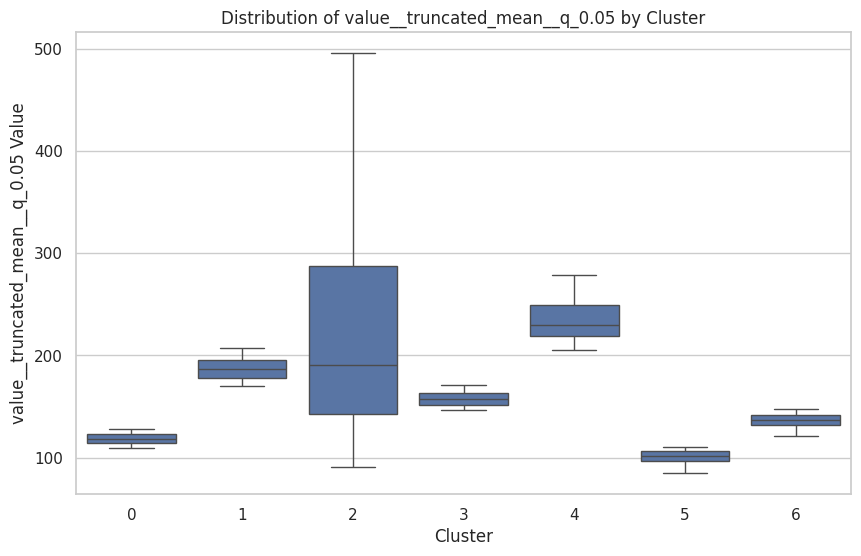

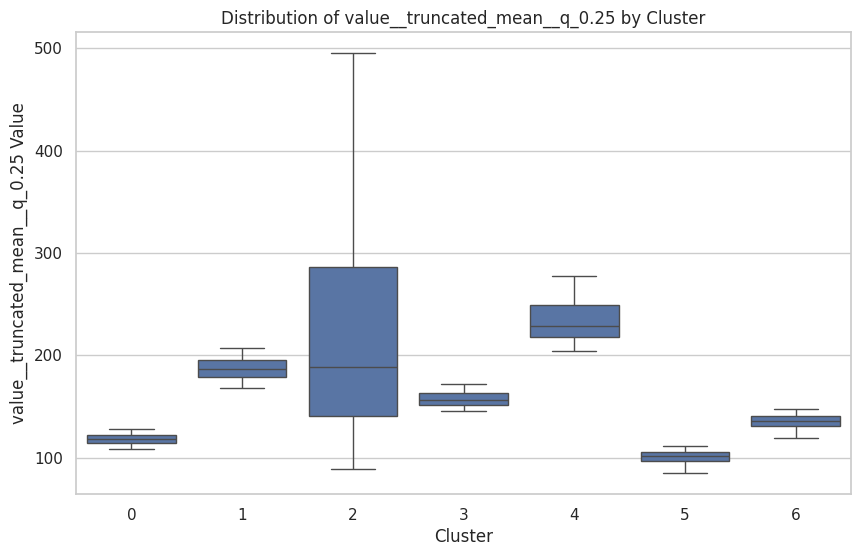

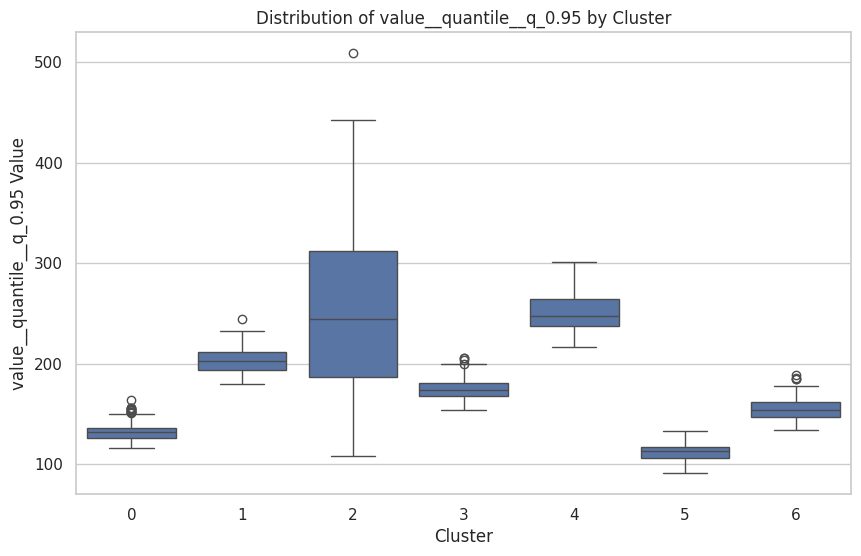

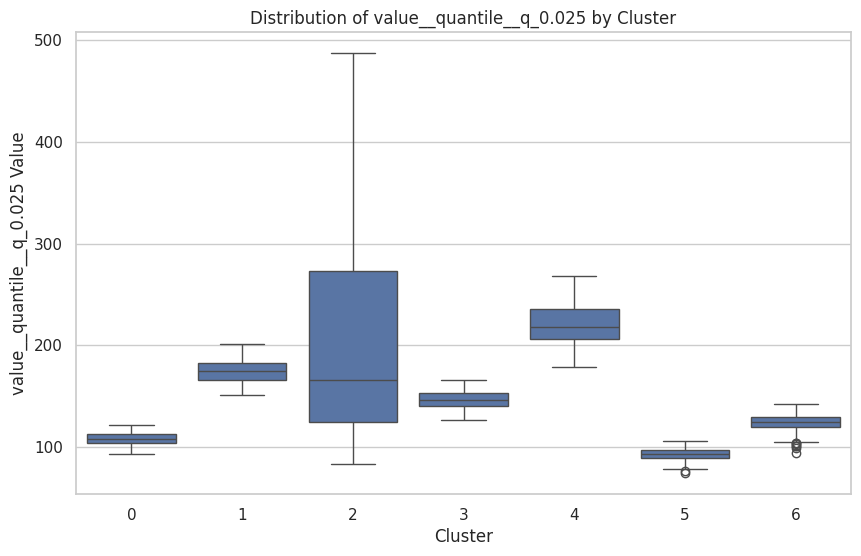

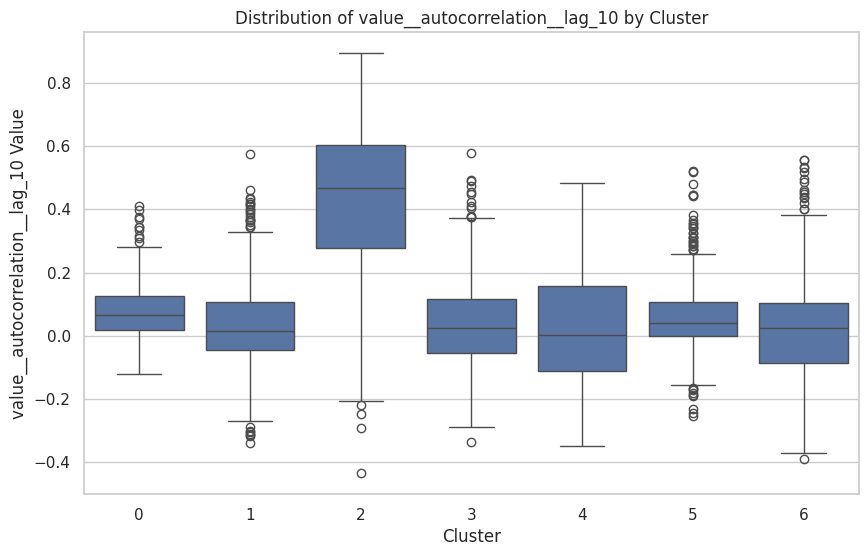

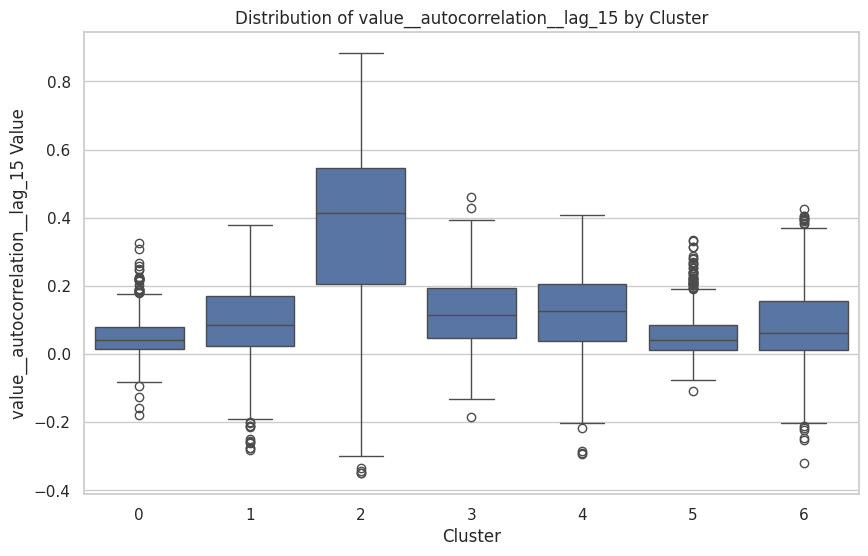

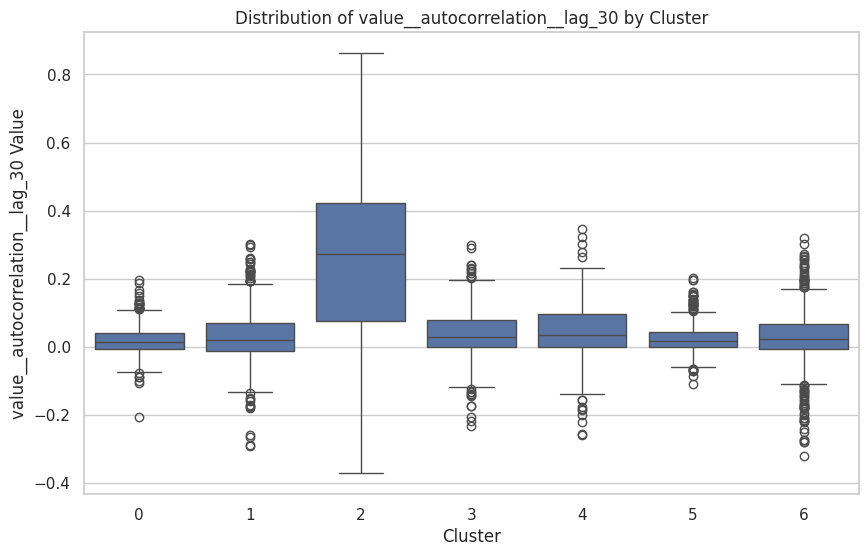

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot size and style

# Set the plot size and style
sns.set(style="whitegrid")

# Loop through each feature and plot a boxplot separately
for feature in [col for col in filtered_features_df.columns if col not in ['id', 'cluster']]:
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    sns.boxplot(x='cluster', y=feature, data=filtered_features_df)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'{feature} Value')
    plt.show()

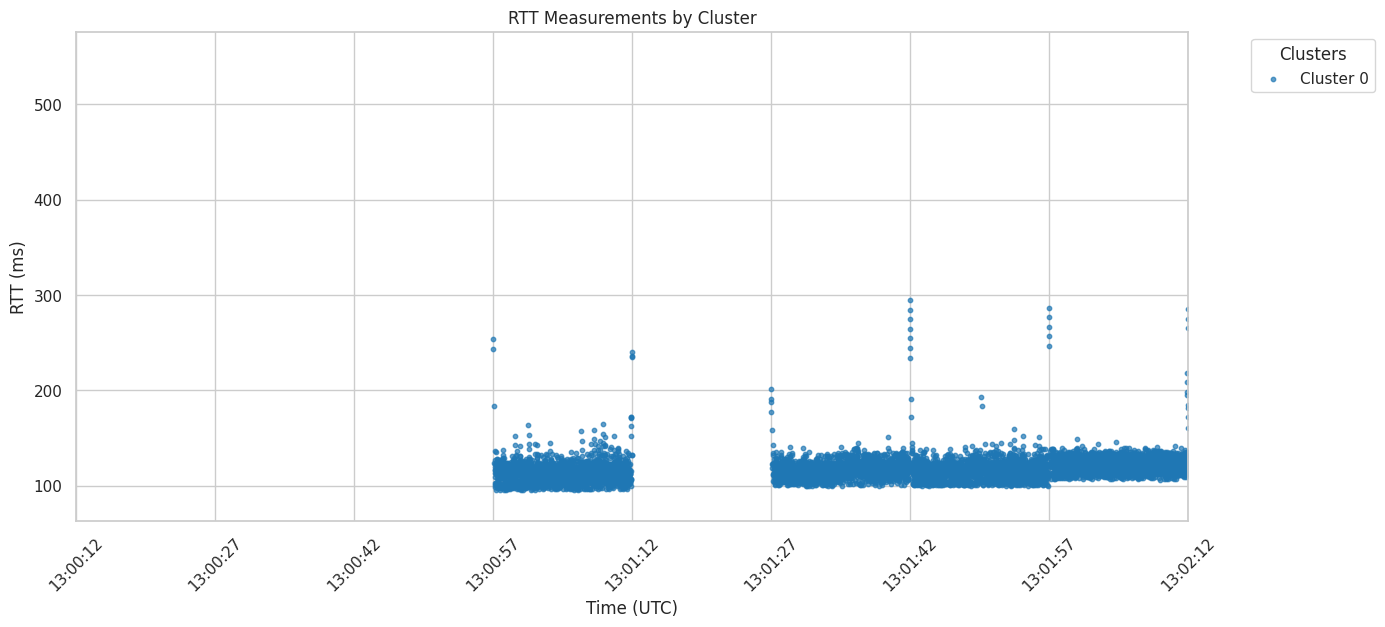

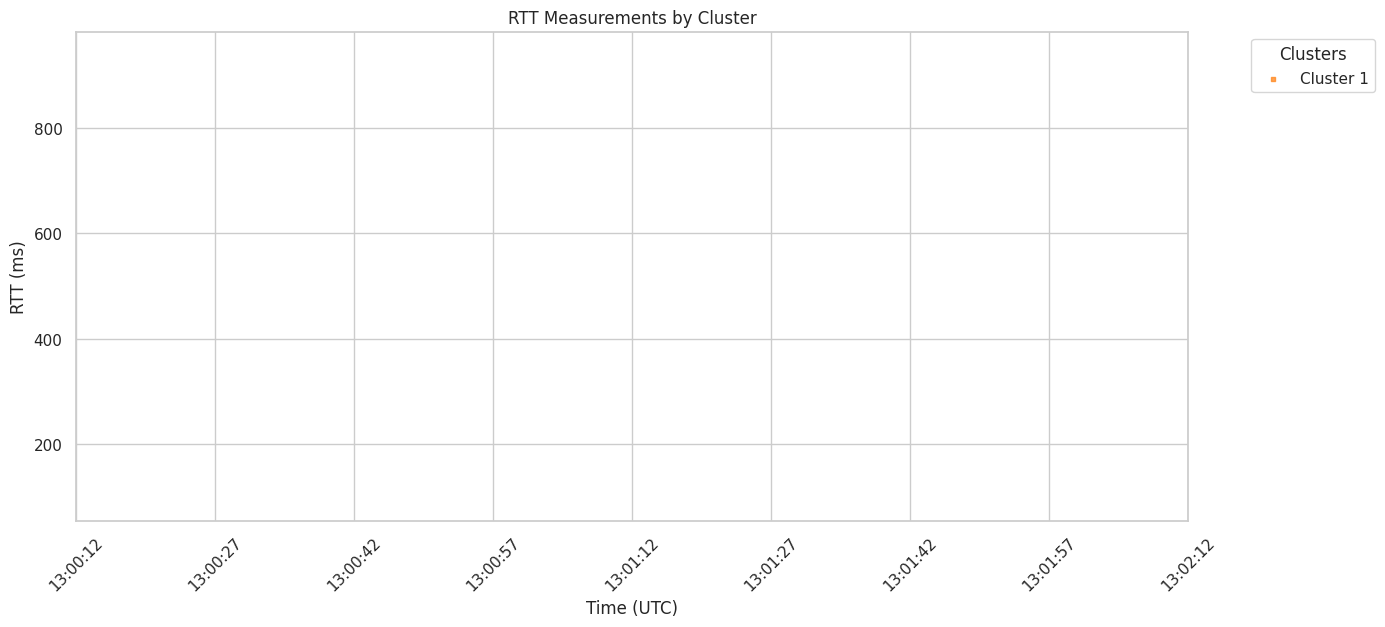

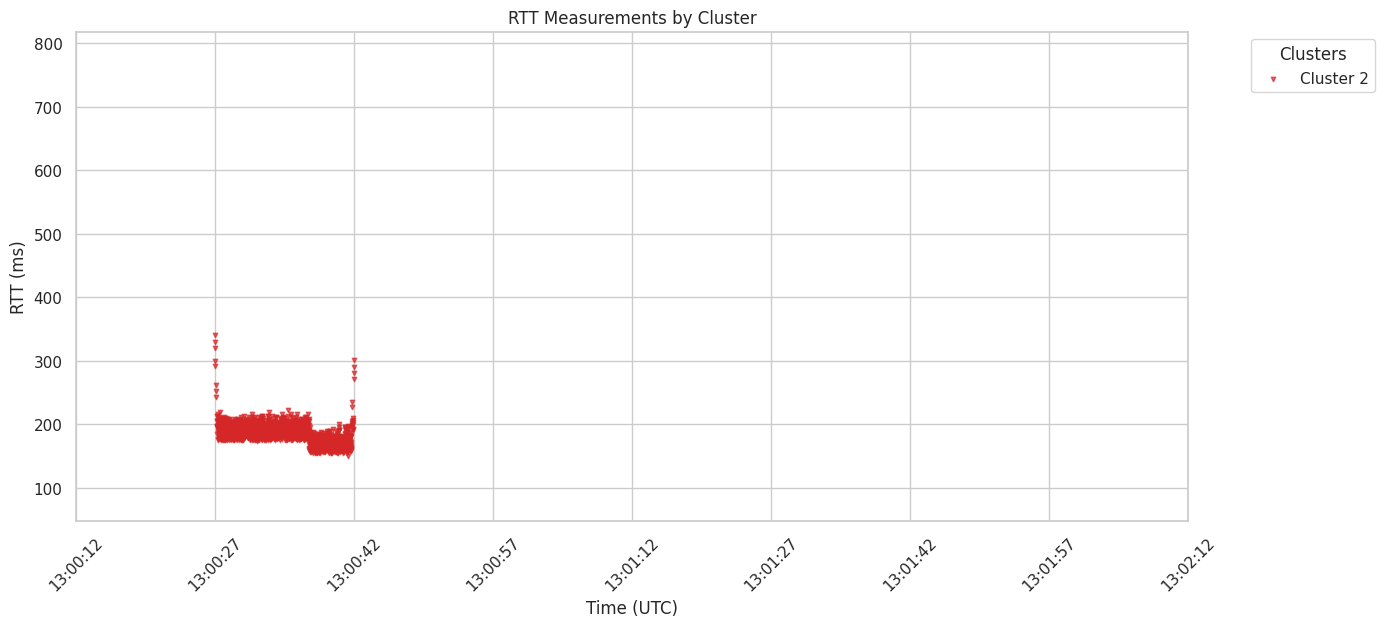

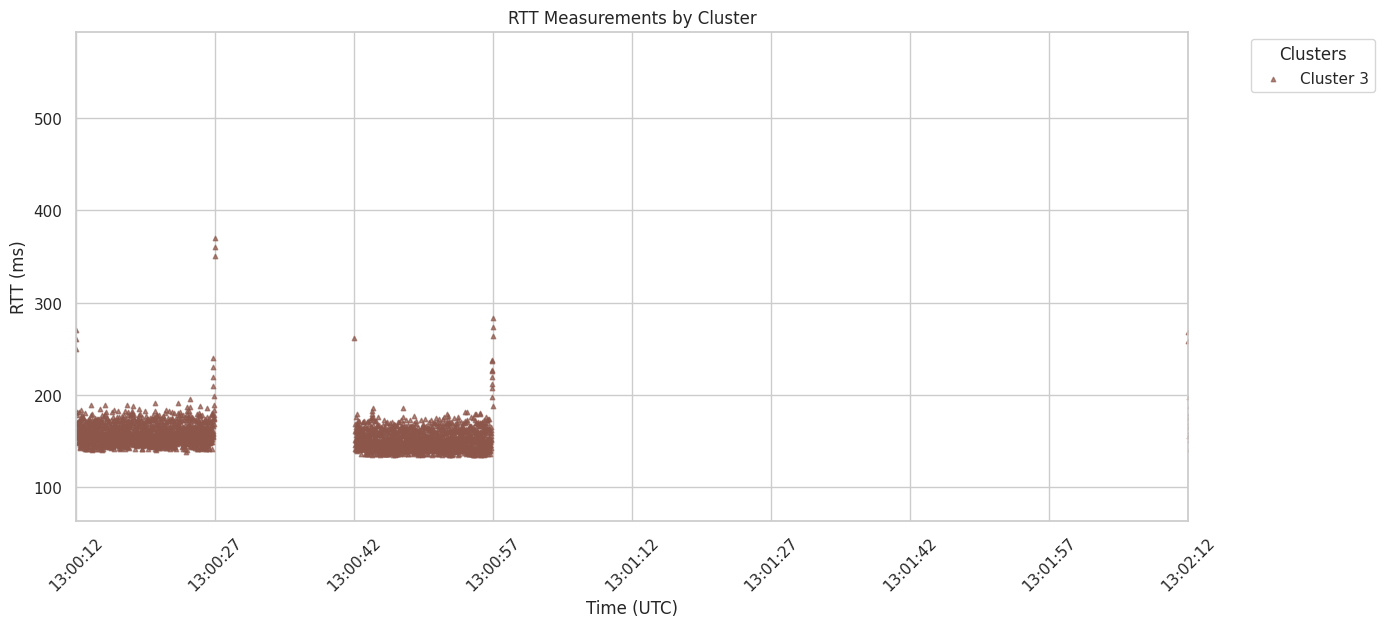

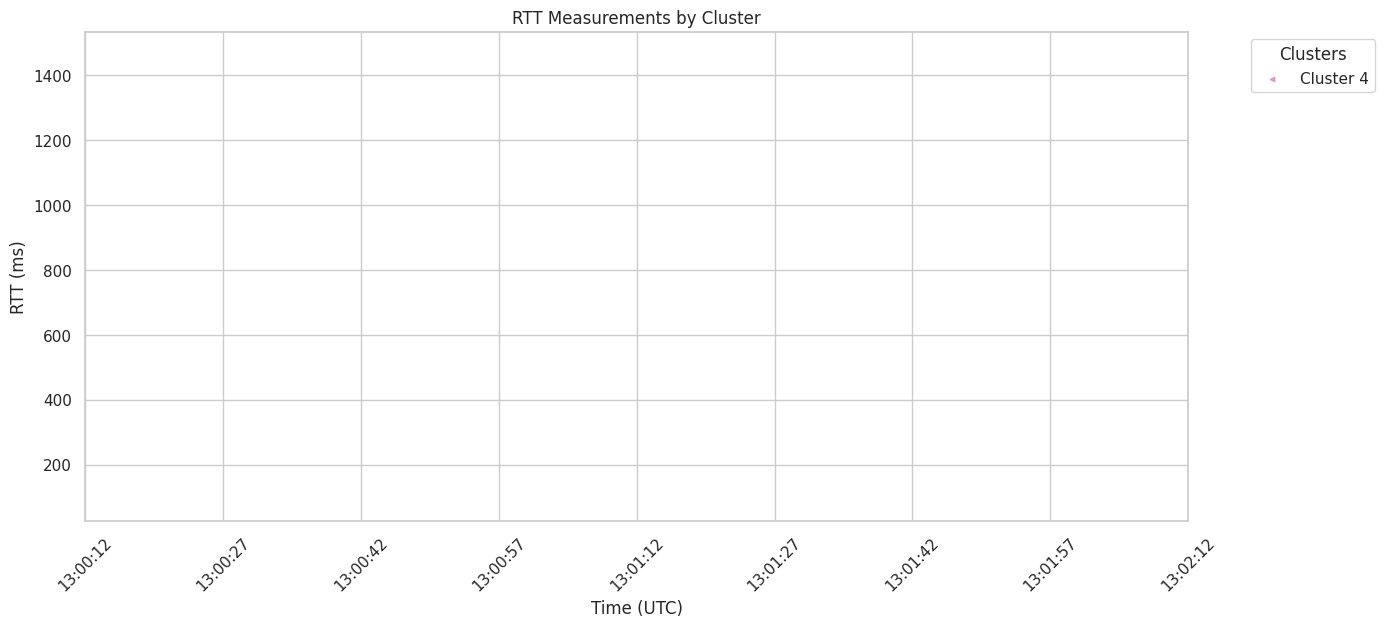

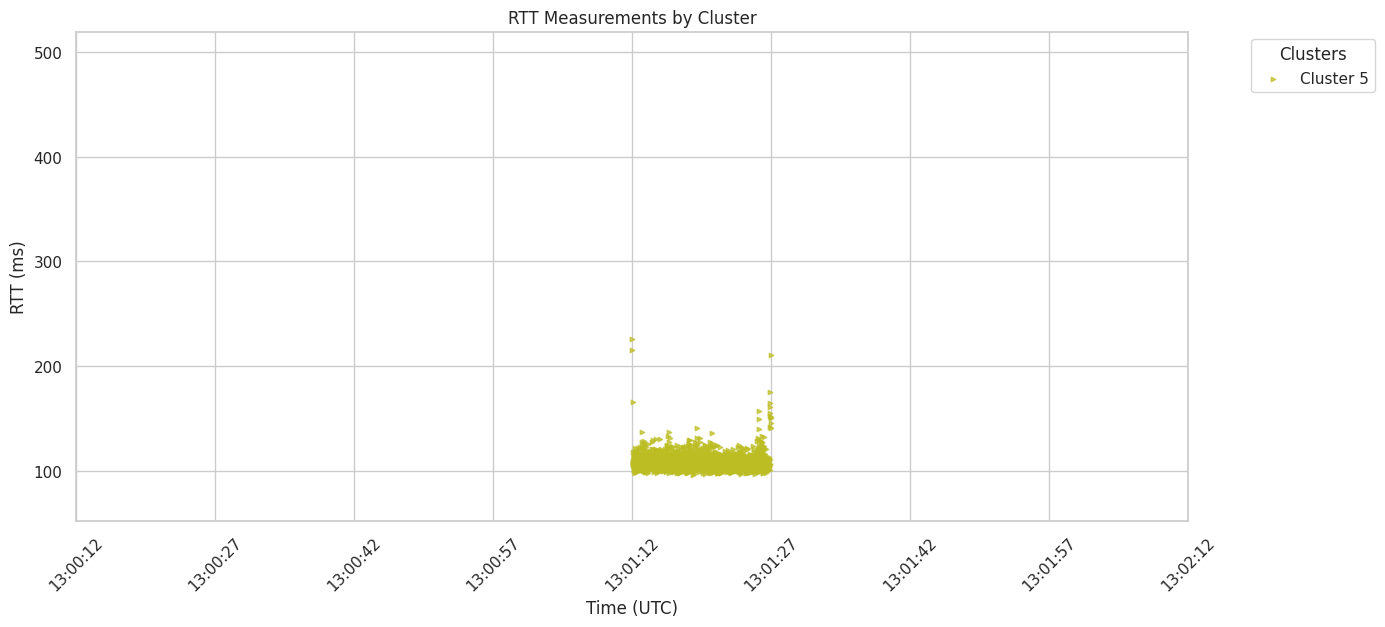

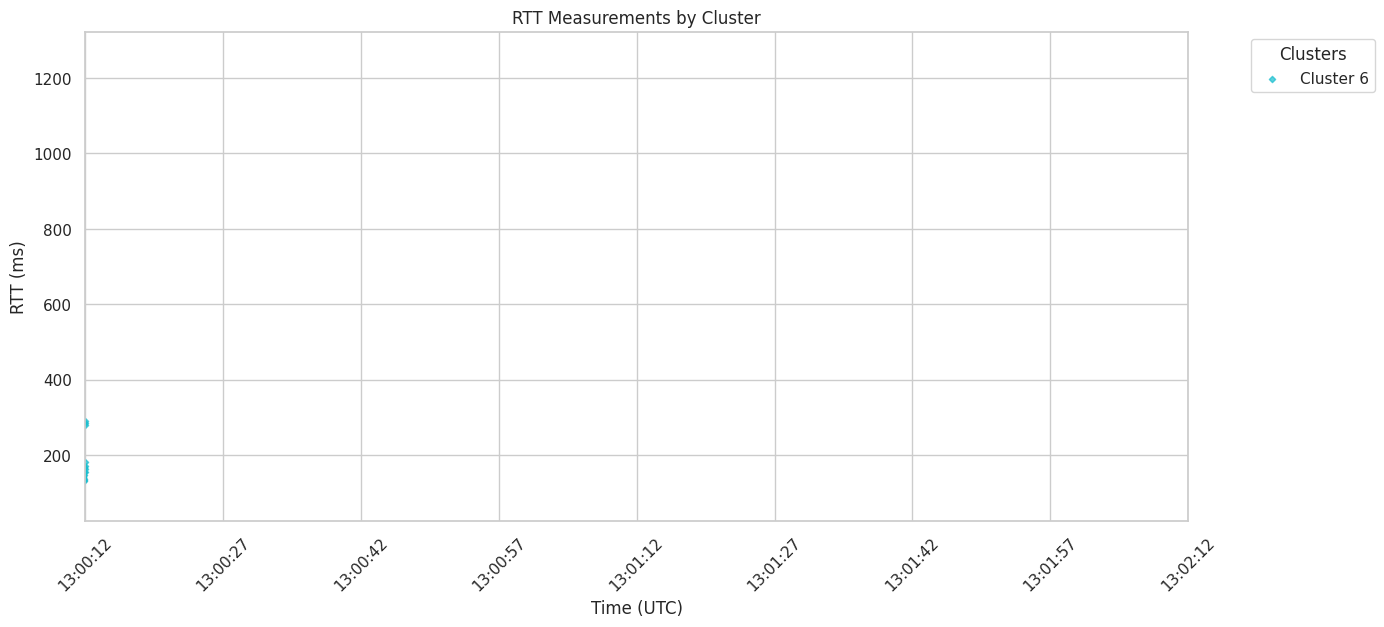

In [ ]:
df_clustered["timestamp"] = pd.to_datetime(df_clustered["timestamp"])
start_time = datetime(2024, 1, 24, 13, 0, 12)
end_time = start_time + pd.Timedelta(2, unit="min")

# Setup plot
unique_clusters = sorted(df_clustered["cluster"].unique())
markers = ['o', 's', 'v', '^', '<', '>', 'D', 'P', '*', 'X', 'H']  # at least 11 distinct markers
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))     # tab10 supports up to 10 distinct colors

# Plot each cluster separately
for idx, cluster_id in enumerate(unique_clusters):
    cluster_data = df_clustered[df_clustered["cluster"] == cluster_id]
    plt.figure(figsize=(14, 6))
    plt.scatter(
        cluster_data["timestamp"],
        cluster_data["value"],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        s=10
    )

    # Final plot styling
    plt.title("RTT Measurements by Cluster")
    plt.xlabel("Time (UTC)")
    plt.xlim(start_time, end_time)
    plt.xticks(pd.date_range(start_time, end_time, freq="15s", unit="s"))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    plt.ylabel("RTT (ms)")
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

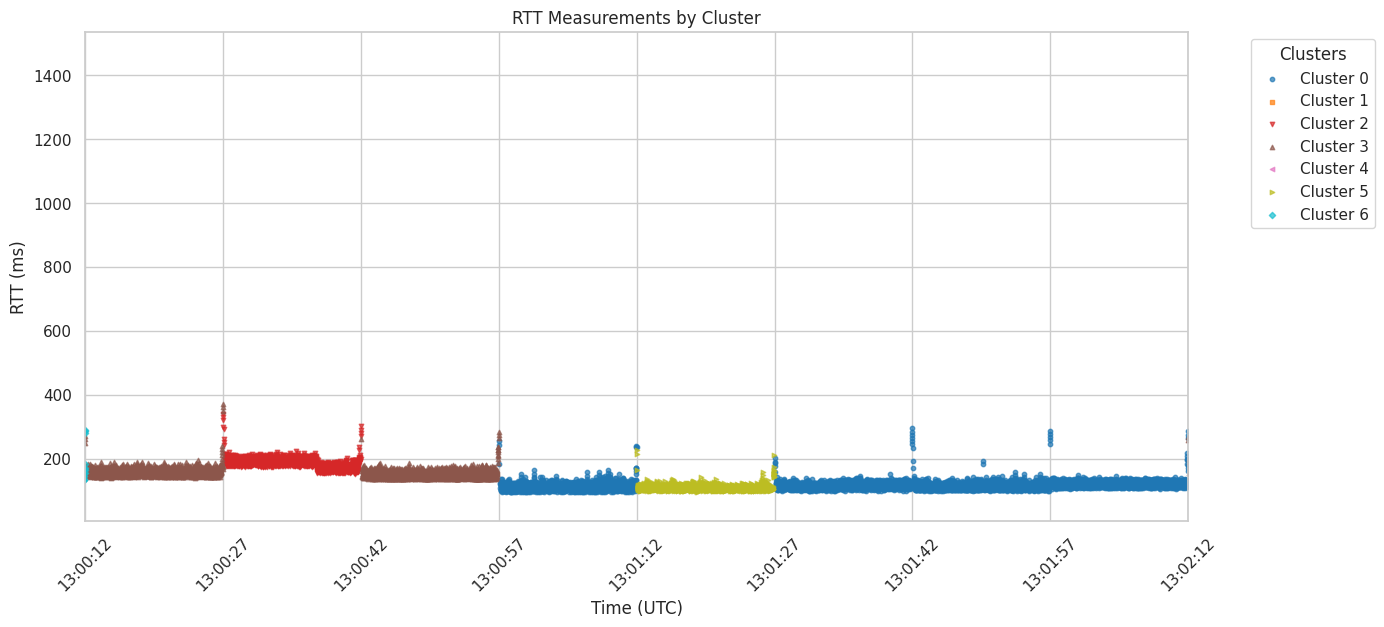

In [ ]:
df_clustered["timestamp"] = pd.to_datetime(df_clustered["timestamp"])

# Setup plot
unique_clusters = sorted(df_clustered["cluster"].unique())
markers = ['o', 's', 'v', '^', '<', '>', 'D', 'P', '*', 'X', 'H']  # at least 11 distinct markers
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))     # tab10 supports up to 10 distinct colors
plt.figure(figsize=(14, 6))
# Plot each cluster separately
for idx, cluster_id in enumerate(unique_clusters):
    cluster_data = df_clustered[df_clustered["cluster"] == cluster_id]
    plt.scatter(
        cluster_data["timestamp"],
        cluster_data["value"],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        s=10
    )

# Final plot styling
plt.title("RTT Measurements by Cluster")
plt.xlabel("Time (UTC)")
plt.ylabel("RTT (ms)")
plt.xlim(start_time, end_time)
plt.xticks(pd.date_range(start_time, end_time, freq="15s", unit="s"))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()